In [12]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataset import MapDataset
import config
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.io import read_image
import albumentations as A 
import os
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(65536, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
       # self.N.loc = self.N.loc.device() 
       # self.N.scale = self.N.scale.device()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 65536)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 256, 256))

In [16]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
def train(autoencoder, data, epochs=1):
    opt = torch.optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(data, unit = "batch") as t:
            for x in t:
                x = x.to(device) 
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
                loss.backward()
                opt.step()
                total_loss += loss.item()
                t.set_postfix(loss=loss.item())
        average_loss = total_loss / len(data)
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")
        
    return autoencoder

In [18]:
class CustomImageDataset(Dataset):
    
    def __init__(self, img_dir, transform = None, target_transform = None):
        self.img_dir = img_dir
        self.list_files = [f for f in os.listdir(self.img_dir) if f.endswith('.tiff')]
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.img_dir, img_file)
        image = np.array(Image.open(img_path))
        
        transform = A.Compose(
            [A.Resize(width=256, height=256),]
        )
        
        transform_only_input = A.Compose(
            [
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.2),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
            ToTensorV2(),
            ]
        )
        
        
        image = transform(image = image)["image"]
        image = transform_only_input(image = image)["image"]
       
        return image

In [19]:
data = CustomImageDataset(img_dir ="/Users/deniztekin/Documents/Programme/Masterarbeit/images/AB")

In [20]:
dataloader = DataLoader(data, batch_size=64, shuffle=True)

In [21]:
latent_dims = 100000
vae = VariationalAutoencoder(latent_dims).to(device) 
vae = train(vae, data)

100%|████████████████████████| 114/114 [04:09<00:00,  2.19s/batch, loss=2.83e+5]

Epoch 1/1, Average Loss: 1237855.5201


In [22]:
def plot_latent(vae, data, num_batches=100):
    for i, x in enumerate(data):
        z = vae.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

/var/folders/cb/jzh6dpzn7cjd4646q0f0k49w0000gn/T/ipykernel_1425/466274820.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], cmap='tab10')


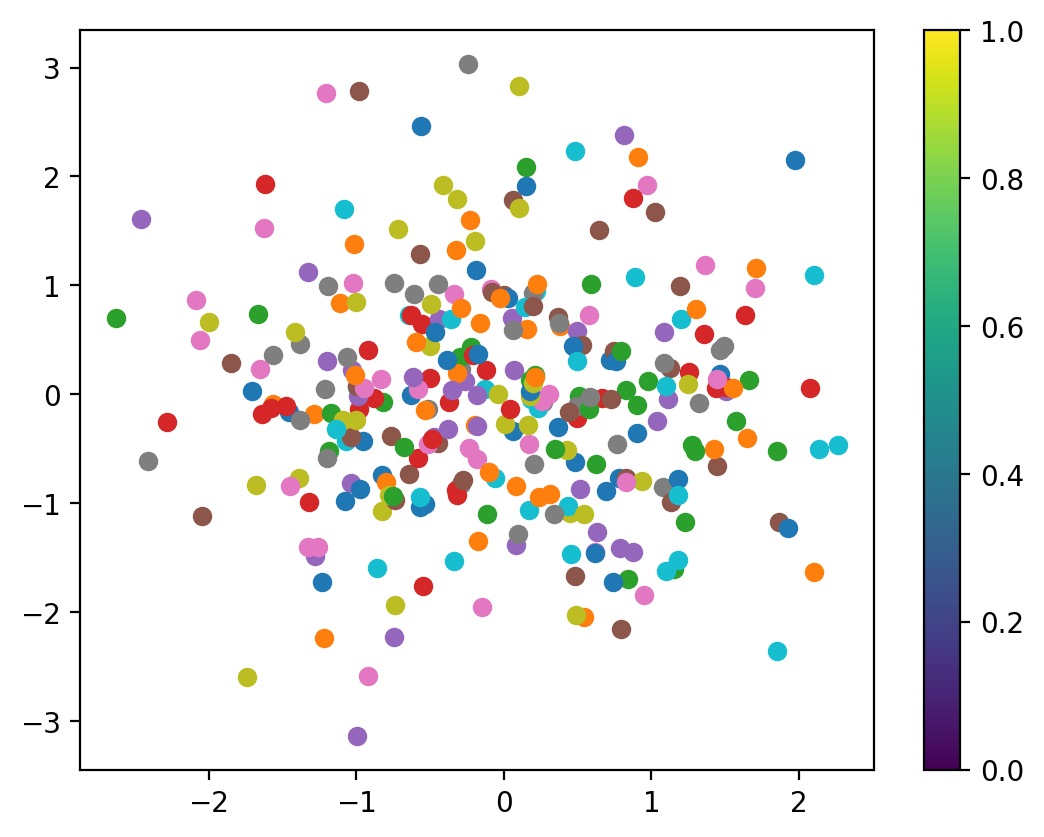

In [23]:
plot_latent(vae, data)

In [53]:
latent_vector = torch.randn(1, latent_dims) 

In [54]:
with torch.no_grad():
    generated_image = vae.decoder(latent_vector)

In [55]:
generated_image = generated_image.view(generated_image.size(0), 1, 256, 256)

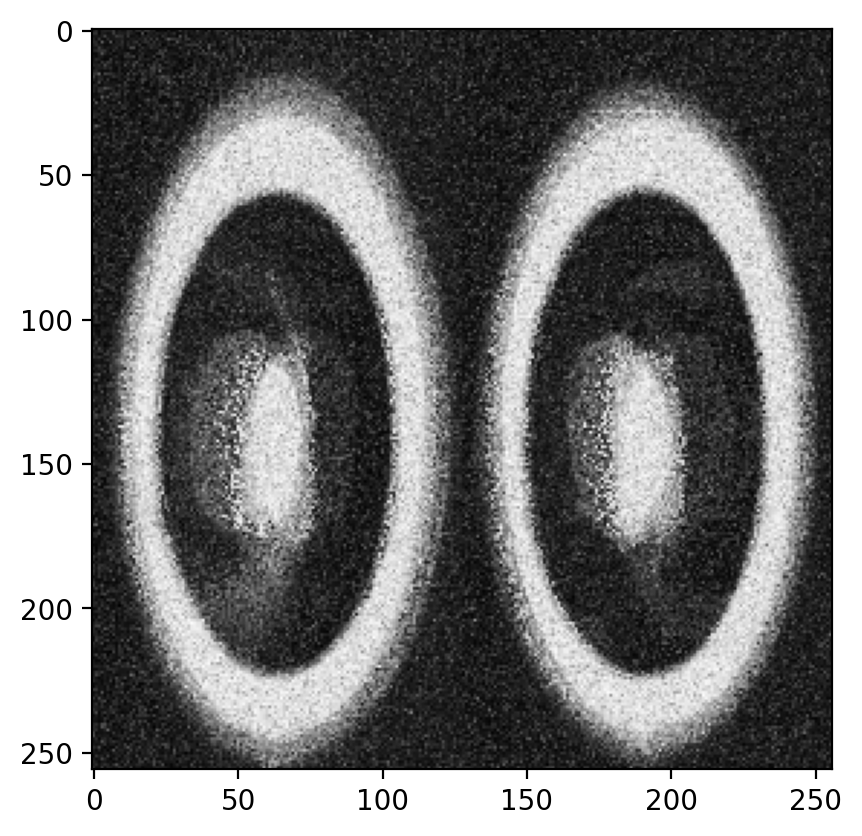

In [56]:
plt.imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
plt.show()